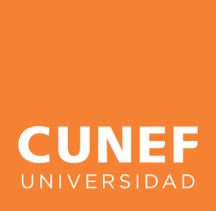

Realizado por:

***Sergio Ranz Casado***  
***Marcos Medina Cogolludo***

---

Una vez realizado el EDA, y teniendo en cuenta el notebook 0.1. donde realizamos una primera exploración rapida de datos. Realizamos el preprocesamiento de datos. En este sentido estos son los puntos que  trataremos:

**2.0.1. Limpieza del dataset:**
----
1. Eliminación de los duplicados.  
2. Eliminación de valores anómalos. (Vehiculos del 2015 que han tenido un accidente en el 2014). 
3. Agrupación de los valores por accidente. 
 

**2.0.2. Analisis de las variables:**
---
4. Analisis de la distribución. 
5. Analisis outliers variables continuas. 
6. Correlacción variables continuas. 
7. Eliminación de las variables correlaccionadas. Si procede.
8. Analisis variable objetivo. 

**2.0.3. SPLIT:**
----
9.  División Train y Test.
10. Igualar la muestra de Train. 
11. Tratamiento de variables numericas. Distribución continua. 
12. Tratamiento de variables categoricas. Distribución discreta. 

**2.0.4. SELECCIÓN DE VARIABLES:**
----
13. Selección de variables. 

---

#### Importo librerias: 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import pyarrow.csv as pv
import pyarrow.parquet as pq
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import pandas as pd
import pyarrow.csv as pv
import pyarrow.parquet as pq
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
from sklearn.utils import resample

---

#### Importo el dataset guardado en el preprocesing 2.0.2.

In [3]:
df_acc = pd.read_parquet('../data/df_acc_1.parquet')
df_acc.columns = df_acc.columns.map(lambda x: x[:].lower())
df_acc

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,c_raln,c_traf,c_nums
0,1999,01,1,00,2,01,01,01,1,4,1,18,1
1,1999,01,1,00,2,01,01,01,1,5,1,18,1
2,1999,01,1,00,2,01,01,01,2,1,1,18,1
3,1999,01,1,00,2,01,01,01,6,3,2,18,2
4,1999,01,1,00,2,01,01,UU,1,2,3,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850312,2014,12,7,UU,2,02,UU,02,U,U,1,03,2
1850313,2014,UU,U,14,2,01,02,01,1,5,4,18,1
1850314,2014,UU,U,22,1,01,06,01,2,4,Q,18,2
1850315,2014,UU,U,23,2,01,06,05,1,1,U,18,1


---

#### Tratamiento de la variable objetivo

Hacemos un label encoder de c_sev, lo que no afectará en nada, simplemente los 1 pasarán a ser 0 y los 2 pasarán a ser 1. 

A partir de ahora las variables de c_sev serán: 

- 0: Accidente con mortalidad.
- 1: Accidente sin mortalidad. 

In [4]:
df_acc["c_sev"] = preprocessing.LabelEncoder().fit_transform(df_acc[["c_sev"]])

#### SPLIT (train y test)

Realizaremos el Split con la estratificación. Esta tecnica la emplearemos en la división del train y test, pues split tiene este parametro dentro de su división. Tendremos que tener en cuenta lo que implica esto, y es que reducimos el numero de muestras de la clase mayoritaria (no mortalidad), por lo que podria suponer una perdida de información.

In [5]:
X = df_acc.drop("c_sev", axis=1)
Y = df_acc["c_sev"]

Hacemos el split, como semilla introducimos 1422.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25, random_state=1422)

Asignamos el x_train y x_test concatenado a y_train e y_test respectivamente, a otras variables para su transformación:

In [7]:
x_train_t = pd.concat([x_train, y_train], axis=1)
x_test_t = pd.concat([x_test, y_test], axis=1)

---

#### Igualar las muestras

Existen diferentes opciones de cara a igualar el dataset, tras leernos diferentes enlaces, hemos pensado en probar las siguientes soluciones: 

- Probar los modelo sin realizar ningún ajuste en la muestra. Aplicaremos la compensación en cada uno de los modelos implementados con el parametro "class_weight='balenced'". Tendremos que tener en cuenta que las metricas serán diferentes. Como queremos probabilidades y tenemos el dataset desajustado, tendremos que usar el BRIER SCORE. Si queremos la clasificación por etiquetas, tendremos que tener en cuenta que a la hora de predecir, para nosotros son mas costosas las muertes no predecidas que las no muertes no predecidas, por lo que tendremos que usar un F2 Score. 


- Usamos un downsampling aleatorio que equilibra el dataset de muertes con no muertes en un 60% a 40%. Al ser un muestreo aleatorio conservamos la distribución del dataset.  


- Undersampling con Tomek-Links. Esta tecnica supone tambien una reducción de la muestra de la clase mayoritaria, seguimos perdiendo información, pero lo bueno de esta técnica es que se centra en coger los datos de las NO MUERTES mas cercanos a los datos de las MUERTES, por lo que la frontera queda mucho mejor definida que en la estratificación. Lo que puede ser de gran ayuda sobre todo el problemas de clasificación binarios. 


- SMOTE: Tecnicas de oversampling, que al contrario que las dos anteriores se centra en la clase minoritaria (muertes). En este sentido crea datos muy parecidos a la muestra de mortalidad hasta equilibrarlos con los de la clase mayoritaria (no muertes). El problema de esta tecnica es que crea información falsa. Lo bueno, que igual te tomek-links, crea registros muy cercanos a la clase minoritaria lo que permite hacer una frontera entre las dos clases de datos que puede facilitar la predicción sobre todo en problemas binarios como el que tenemos. 


- Por ultimo podemos probar una combinación de TOMEK_LINKS con SMOTE. 

**Actualización** Probamos la estratificación en el undersampling aleatorio. 

In [8]:
muestra_minoritaria = x_train_t[(x_train_t.c_sev == 0)]
muestra_mayoritaria = x_train_t[(x_train_t.c_sev == 1)]

Queremos una proporción de 40% muertes y 60% no muertes, solo vamos a reducir la muestra mayoritaria, para calcular al numero de muestras que la vamos a reducir, vamos a usar una regla de 3. 

In [9]:
muestra_mayoritaria_reducida = resample(muestra_mayoritaria, replace=True, n_samples=40320, random_state=1234)

In [10]:
x_train_t = pd.concat([muestra_mayoritaria_reducida, muestra_minoritaria]).reset_index().drop('index', axis=1)

In [11]:
y_train = x_train_t['c_sev']

---

#### Tratamiento de variables numericas.

Tal y como hemos comentado en el apartado 2.0.2 las variables numericas de este dataset son: c_nums, c_vehs y c_year. 

- La variable **C_year** no tiene ni na y sigue una distribución uniforme. Hemos decidido no aplicar ningun tipo de tratamiento a esta variable. 


- La variable **C_nums** sigue una distribución de Poisson marcada por muchos valores atipicos. Sin embargo estos valores atipicos no suponen una gran representatividad de las muertes, emplearemos un RobustScaler. 


- La variable **C_vehs** contiene numeros que son NA y '', los sustituiremos por un outlier en este caso **99**. La distribución que sigue esta variable es una Poisson con muchos valores atipicos por lo que tambien emplearemos un RobustScaler. 


El [`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler) se caracteriza por transformar los datos empleando estadísticos robustos a los valores atípicos (*outliers*). La transformación se realiza suprimiendo la mediana y escalando los datos de acuerdo con su rango intercuartílico.

**C_NUMS:**

In [12]:
x_train_t["c_nums"] = preprocessing.RobustScaler().fit_transform(x_train_t[["c_nums"]])
x_test_t["c_nums"] = preprocessing.RobustScaler().fit_transform(x_test_t[["c_nums"]])

**C_VEHS**: 

In [13]:
x_train_t["c_vehs"] = x_train_t["c_vehs"].replace("UU", 99)
x_train_t["c_vehs"] = x_train_t["c_vehs"].replace("", 99)
x_test_t["c_vehs"] = x_test_t["c_vehs"].replace("UU", 99)
x_test_t["c_vehs"] = x_test_t["c_vehs"].replace("", 99)

In [14]:
x_train_t["c_vehs"] = preprocessing.RobustScaler().fit_transform(x_train_t[["c_vehs"]])
x_test_t["c_vehs"] = preprocessing.RobustScaler().fit_transform(x_test_t[["c_vehs"]])

-----

#### Tratamiento variables categoricas.

Las variables categoricas de este dataset son las siguientes: `c_mnth`(numero de meses), `c_hour`(hora del dia), `c_wday`(dia de la semana), `c_conf`(configuración del accidente), `c_rcfg`(configuración calzada), `c_wthr`(configuración tiempo), `c_rsur`(superficie de la carretera), `c_raln`(alineación carretera), `c_traf`(señalización de la carretera). 

Queremos dividir estas variables en dos grandes grupos para diferenciar su tratamiento: 

- Primer grupo (Variables `c_mnth, c_wday y c_hour`): , son variables muy parecidas a numericas, que nosotros consideramos categoricas. En este sentido y viendo su distribución en el preprocesamiento 2.0.2. Hemos decidido cambiar los NA por el valor de la mediana para las variables c_mnth y c_wday. Mientras que para c_hour hemos decidido añadir una categoria mas llamada '24'. (Falta comentar la incidencia de los NA de estas variables). Como son variables ya codificadas y ordenadas no vamos a hacer label encoder ya que no tendria ningun sentido.


- Segundo grupo (Resto variables): Son variables que, aunque tienen numeros, estos no están ordenados, por lo que hemos decidido introducir un **Weight of Evidence Encoding** Este metodo se emplea para variables objetivo binarias y lo que hace es medir la distinción de cada categoría de la variable con respecto a la variable objetivo. 

**Primer Grupo:**

In [15]:
'''c_hour Train: '''
x_train_t["c_hour"] = x_train_t["c_hour"].replace("UU", 24)
x_train_t["c_hour"] = pd.to_numeric(x_train_t["c_hour"])
'''c_hour Test: '''
x_test_t["c_hour"] = x_test_t["c_hour"].replace("UU", 24)
x_test_t["c_hour"] = pd.to_numeric(x_test_t["c_hour"])

In [16]:
'''c_wday Train: '''
x_train_t["c_wday"] = x_train_t["c_wday"].replace("U", np.nan)
x_train_t["c_wday"] = pd.to_numeric(x_train_t["c_wday"])
x_train_t["c_wday"] = x_train_t["c_wday"].replace(np.nan, np.nanmedian(x_train_t["c_wday"])).astype(int)

'''c_wday Test: '''
x_test_t["c_wday"] = x_test_t["c_wday"].replace("U", np.nan)
x_test_t["c_wday"] = pd.to_numeric(x_test_t["c_wday"])
x_test_t["c_wday"] = x_test_t["c_wday"].replace(np.nan, np.nanmedian(x_test_t["c_wday"])).astype(int)

In [17]:
'''c_mnth Train: '''
x_train_t["c_mnth"] = x_train_t["c_mnth"].replace("UU", np.nan)
x_train_t["c_mnth"] = pd.to_numeric(x_train_t["c_mnth"])
x_train_t["c_mnth"] = x_train_t["c_mnth"].replace(np.nan, np.nanmedian(x_train_t["c_mnth"])).astype(int)

'''c_mnth Test: '''
x_test_t["c_mnth"] = x_test_t["c_mnth"].replace("UU", np.nan)
x_test_t["c_mnth"] = pd.to_numeric(x_test_t["c_mnth"])
x_test_t["c_mnth"] = x_test_t["c_mnth"].replace(np.nan, np.nanmedian(x_test_t["c_mnth"])).astype(int)

**Segundo Grupo:**

In [18]:
segundo_grupo = x_train_t[["c_conf", "c_rcfg", "c_wthr", "c_rsur", "c_raln", "c_traf"]].columns
woe = ce.WOEEncoder(cols=segundo_grupo)
x_train_t[segundo_grupo] = woe.fit_transform(x_train_t[segundo_grupo],y_train)
x_test_t[segundo_grupo] = woe.fit_transform(x_test_t[segundo_grupo],y_test)

---

#### Guardamos 

In [19]:
x_train_t.to_parquet("../data/train1.parquet")
x_test_t.to_parquet("../data/test1.parquet")

---

#### ENLACES DE INTERÉS: 

[`MUESTREO EN PYTHON`](https://www.analyticslane.com/2020/06/15/muestreo-en-python/)

[`SMOTE for Imbalanced Classification with Python`](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

[`How to Combine Oversampling and Undersampling for Imbalanced Classification`](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/)

[`Random Oversampling and Undersampling for Imbalanced Classification`](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/)

[`TOMEK LINKS`](https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.TomekLinks.html)

[`10 Techniques to deal with Imbalanced Classes in Machine Learning`](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

[`How to Effortlessly Handle Class Imbalance with Python and SMOTE`](https://towardsdatascience.com/how-to-effortlessly-handle-class-imbalance-with-python-and-smote-9b715ca8e5a7)

[`Weight of Evidence Encoding`](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html)

[`Clasificación con datos desbalanceados`](https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/)

---